# Model inspection 
> After generating a model we inspect it here to learn how feature distributions differ between top and bottom quality predictions and which features are particularly relevant using SHAP values.

In [ ]:
#default_exp inspection

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble, decomposition
import pickle
from kaggle_house_prices.utils import *
from kaggle_house_prices.preprocessing import *
from kaggle_house_prices.modelling import *
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import shap

In [ ]:
mpl.style.use('bmh')

## Loading data and model

Loading the `TabularPandas` object

In [ ]:
with open(model_data_path, "rb") as f:
    to = pickle.load(f)

Creating data loaders

In [ ]:
dls = to.dataloaders()

In [ ]:
#hide
dls.show_batch()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,GarageYrBlt_na,LotFrontage_na,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,BsmtFinSF1,LowQualFinSF,SalePrice
0,96,60,RL,Pave,#na#,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,Ex,Gd,PConc,Gd,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,0,0,2,1,3,1,TA,6,Typ,1,TA,BuiltIn,Fin,2,TA,TA,Y,0,0,0,0,#na#,#na#,Shed,480,4,WD,Normal,False,True,9764.999985,1993.000001,1993.000000,68.000002,-0.000001,370.000001,679.999990,680.000012,789.999990,1470.000001,1993.000000,419.999999,2.320000e+02,63.000000,65.000000,310.000001,1.280123e-08,12.128111
1,1292,160,RM,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,5,7,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,0,0,2,1,3,1,TA,6,Typ,0,#na#,Detchd,Unf,1,TA,TA,Y,0,0,0,0,#na#,#na#,#na#,0,2,WD,Normal,False,False,1679.999811,1972.000000,1972.000000,268.000002,-0.000001,399.000007,629.999996,630.000020,672.000003,1302.000001,1972.000000,264.000000,1.850000e+02,-0.000001,21.000002,231.000002,1.280123e-08,11.691072
2,1302,70,RL,Pave,#na#,IR1,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,6,7,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,Fa,Y,SBrkr,0,0,1,0,3,1,Gd,7,Typ,2,Gd,Attchd,Unf,1,TA,TA,P,0,0,224,0,#na#,#na#,#na#,0,11,WD,Normal,False,True,7500.000035,1942.000001,1950.000000,-0.000001,-0.000001,223.999998,771.000011,753.000006,740.999987,1494.000002,1941.999999,213.000006,-1.468373e-07,-0.000001,65.000000,547.000000,1.280123e-08,12.086726
3,451,30,RM,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,8,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Ex,Y,FuseA,0,0,1,0,2,1,Gd,5,Typ,0,#na#,Detchd,Unf,1,Fa,Fa,N,0,0,0,0,#na#,#na#,#na#,0,6,WD,Normal,False,False,5684.000122,1930.000001,2005.000000,-0.000001,-0.000001,813.000003,812.999990,812.999991,0.000010,813.000006,1932.000003,269.999999,-1.468373e-07,113.000001,70.000000,-0.000006,1.280123e-08,11.608235
4,853,75,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2.5Unf,7,5,Gable,CompShg,MetalSd,MetalSd,None,TA,Gd,CBlock,TA,TA,No,Rec,Unf,GasA,Gd,Y,SBrkr,0,0,2,0,4,1,TA,7,Typ,2,Gd,Detchd,Unf,1,TA,TA,Y,0,0,126,0,#na#,MnPrv,#na#,0,8,WD,Normal,False,False,7127.999971,1940.999999,1950.000000,-0.000001,-0.000001,554.000001,918.000003,918.000006,727.999992,1646.000006,1941.000000,239.999994,-1.468373e-07,-0.000001,53.000000,364.000000,1.280123e-08,12.007622
5,682,50,RH,Pave,Pave,IR2,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,Gable,CompShg,VinylSd,Stucco,None,TA,TA,BrkTil,TA,TA,No,Rec,Unf,GasA,Ex,Y,SBrkr,0,0,1,0,3,1,TA,6,Typ,0,#na#,Detchd,Unf,1,TA,TA,Y,56,0,0,0,#na#,#na#,#na#,0,7,WD,Abnorml,False,False,4499.999864,1931.999999,2000.000001,-0.000001,-0.000001,611.000001,792.999992,848.000004,672.000003,1520.000003,1968.000000,280.999998,-1.468373e-07,-0.000001,55.000001,182.000003,1.280123e-08,11.979385
6,857,80,RL,Pave,#na#,IR1,Low,AllPub,Inside,Mod,CollgCr,Norm,Norm,1Fam,SLvl,6,6,Gable,CompShg,Plywood,HdBoard,None,TA,TA,CBlock,Gd,Gd,Gd,GLQ,LwQ,GasA,TA,Y,SBrkr,1,0,1,0,3,1,TA,5,Typ,0,#na#,Detchd,Unf,2,TA,Fa,Y,34,0,0,0,#na#,MnPrv,#na#,0,10,WD,Normal,False,True,10969.999979,1978.000000,1978.000000,-0.000001,434.999993,-0.000014,939.999

Reconstructing the `Learner` object

In [ ]:
loss_fun = torch.nn.functional.mse_loss
y_range = [min(to.valid.ys.values.min(), to.train.ys.values.min()), 
           max(to.valid.ys.values.max(), to.train.ys.values.max())]
learn = tabular_learner(dls, n_out=1, loss_func=loss_fun, config=dict(active_fun=Mish), y_range=y_range)

In [ ]:
learn.load("model-final")

## Visualizing embeddings

The way `TabularModel` 

```python
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
                 y_range=None, use_bn=True, bn_final=False, bn_cont=True):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])  # 👁️‍🗨️
```

initializes the embeddings is via `get_emb_sz` using the order of `to.cat_names`

```python
def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]  # 👁️‍🗨️
```

and predictions are made using the integer contained in the pre-processed `xs`

```python
def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]  # 👁️‍🗨️
```


In [ ]:
cat_names

['Id',
 'MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition']

In [ ]:
# export
def get_objects_and_embeddings(learn:Learner, to:TabularPandas, col:str):
    "Retrieves categories and their embedding vectors"
    ix = list(to.cat_names).index(col)
    X = learn.model.embeds[ix].weight.detach().numpy()
    c = [to.classes[col][_i] for _i in to.xs[col].values]
    return X, c

In [ ]:
col = "Id"
X, c = get_objects_and_embeddings(learn, to, col)
X.shape

(1461, 95)

In [ ]:
#export
def show_embeddings_with_pca(learn:Learner, to:TabularPandas, col:str, **plot_params):
    "Visualizes the first two components of the PCA of embeddigns of `col`"
    X, c = get_objects_and_embeddings(learn, to, col)
    
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    Xh = pca.transform(X)
    
    fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)
    ax.scatter(Xh[:,0], Xh[:,1], marker="o", alpha=.5)
    ax.set_title(f"PCA of '{col}'-embeddings", fontsize=16)
    ax.set(xlabel=f"PCA#1 (exp. var. ratio = {pca.explained_variance_ratio_[0]:.4f})", 
           ylabel=f"PCA#2 (exp. var. ratio = {pca.explained_variance_ratio_[1]:.4f})",
           **plot_params)
    return ax

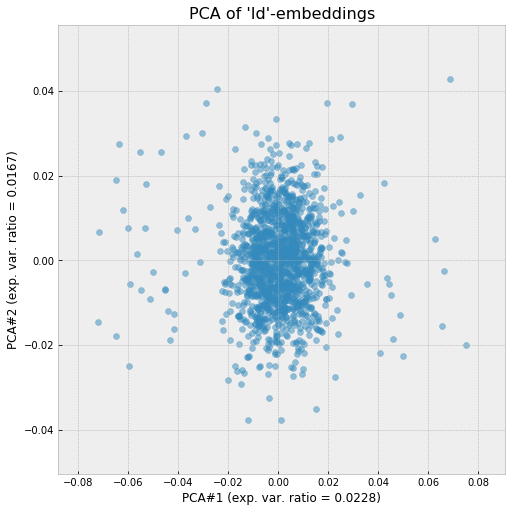

In [ ]:
show_embeddings_with_pca(learn, to, "Id")

## Feature importance

To calculate the feature importance we perturb the features one by one and measure the impact on the loss.

In [ ]:
#hide
display_all(dls.valid.xs.head().T)

,934,710,1026,153,994
Id,935.000000,711.000000,1027.000000,154.000000,995.000000
MSSubClass,1.000000,2.000000,1.000000,1.000000,1.000000
MSZoning,4.000000,4.000000,4.000000,4.000000,4.000000
Street,2.000000,2.000000,2.000000,2.000000,2.000000
Alley,0.000000,0.000000,0.000000,0.000000,0.000000
LotShape,2.000000,1.000000,4.000000,4.000000,4.000000
LandContour,2.000000,4.000000,4.000000,4.000000,4.000000
Utilities,1.000000,1.000000,1.000000,1.000000,1.000000
LotConfig,5.000000,5.000000,5.000000,5.000000,3.000000
LandSlope,2.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#export
def get_df_preds(df:pd.DataFrame, learn:Learner, cat_names:List[str], cont_names:List[str]) -> torch.Tensor:
    "`df` is the `TabularPandas.valid.xs` attribute"
    x_cat = torch.from_numpy(df[cat_names].values).long()
    x_cont = torch.from_numpy(df[cont_names].values).float()
    learn.model.eval()
    return learn.model.forward(x_cat, x_cont)

Making predictions over the validation set using `get_df_preds` and not  `Learner.get_preds` because we want to be able to perturb individual features.

In [ ]:
%%time
y_pred0 = get_df_preds(to.valid.xs, learn, to.cat_names, to.cont_names); y_pred0[:5]

CPU times: user 9.17 ms, sys: 113 µs, total: 9.29 ms
Wall time: 9.49 ms


tensor([[11.9432],
        [11.7848],
        [11.8594],
        [11.7840],
        [11.9642]], grad_fn=<SliceBackward>)

Sanity checking the results are actually the same for unperturbed input

In [ ]:
%%time
y_pred, y_true = learn.get_preds(dl=dls.valid); y_pred[:5]

CPU times: user 20.7 ms, sys: 440 µs, total: 21.1 ms
Wall time: 29.7 ms


tensor([[11.9432],
        [11.7848],
        [11.8594],
        [11.7840],
        [11.9642]])

In [ ]:
#hide
assert torch.allclose(y_pred0, y_pred)

In [ ]:
def get_feature_importance(to:TabularPandas, learn:Learner):
    "Computes the feature importance using `get_df_preds`"
    feature_losses = {}
    
    ref_loss = learn.loss_func(*learn.get_preds()).item()
    ys = torch.from_numpy(to.valid.ys.values).float()
    for col in to.valid.xs.columns:
        xs = to.valid.xs.copy()  # copy the original dataset
        vals = to.valid.xs[col].values
        xs[col] = np.random.choice(vals)  # perturb values of `col`
        _ys = get_df_preds(xs, learn, to.cat_names, to.cont_names)
        
        feature_losses[col] = learn.loss_func(_ys, ys).item()
    
    losses = pd.DataFrame(feature_losses.items(), columns=["column", "loss"])
    losses["loss Δ"] = losses["loss"] - ref_loss

    losses.sort_values("loss Δ", ascending=False, inplace=True)
    
    return losses, ref_loss

In [ ]:
%%time
importances, ref_loss = get_feature_importance(to, learn)

CPU times: user 743 ms, sys: 0 ns, total: 743 ms
Wall time: 752 ms


In [ ]:
display_all(importances.head())

,column,loss,loss Δ
75,GarageArea,0.241992,0.009965
71,1stFlrSF,0.241957,0.009931
78,LotFrontage,0.238454,0.006428
79,BsmtFinSF1,0.237771,0.005745
64,LotArea,0.236979,0.004953


## Inspecting confidently wrong vs correct predictions

In order to find out where the model goes most spectacularly wrong let's plot the worst predictions against the best predictions and compare them by individual features. 

Steps:
1. decode the feature values to make it interpretable
2. get samples with largest ("worst") and smallest ("best") prediction errors over the validation set
3. plot feature distributions for those two groups
4. select/sort the feature distributions shows by largest deviation between the distribution of the two groups

In [ ]:
decoded_xs = to.valid.decode()

### Categorical columns

Visualizing the difference distribution of `dep_var`

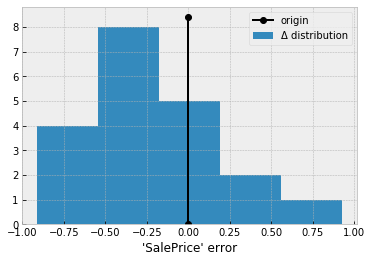

In [ ]:
bins = 5
Δ = (y_pred - y_true).detach().numpy().ravel()

fig, ax = plt.subplots()
ax.hist(Δ, bins=bins, label="Δ distribution")
ax.plot([0,0], [0, ax.get_ylim()[1]], "-ok", label="origin")
ax.legend()
ax.set_xlabel(f"'{dep_var}' error")
plt.show()

In [ ]:
#hide
len(Δ), len(to.valid.xs)

(20, 20)

Indentifying the smallest and largest `n` deviations between prediction and ground truth

In [ ]:
n = 10  # number of best / worst examples
ix = np.argsort(np.absolute(Δ))
best_ix, worst_ix = ix[:n], ix[-n:] 
best, worst = Δ[ix[:n]], Δ[ix[-n:]]; best, worst

(array([ 0.00434017,  0.05659008,  0.10124111, -0.10198593, -0.16936111,
         0.22672558, -0.277215  , -0.2847681 , -0.321908  , -0.35832787],
       dtype=float32),
 array([-0.44784355, -0.45344925,  0.46938133, -0.48436546, -0.51645756,
        -0.5833025 , -0.63909626, -0.76514053, -0.90970325,  0.9257841 ],
       dtype=float32))

Distribution similarity

In [ ]:
#export
def distribution_similarity(best:pd.Series, worst:pd.Series):
    "Computing distribution similarity using `stats.wassertain_distance` assuming index based order"
    if len(worst.values) == 0 or len(best.values) == 0: return np.inf
    return stats.wasserstein_distance(best.values, worst.values)

In [ ]:
distribution_similarity(pd.Series(index=["a", "b", "c"], data=[.1, .8, .1]),
                        pd.Series(index=["a", "b", "c"], data=[.1, .8, .1]))

0.0

In [ ]:
#hide
assert distribution_similarity(pd.Series(index=["a", "b", "c"], data=[.1, .8, .1]),
                               pd.Series(index=["a", "b", "c"], data=[.1, .8, .1])) == 0

Defining functions for the comparison of best/worst distributions

In [ ]:
#export
def element_comp(x:np.ndarray, y:Union[int,float,str]) -> np.ndarray:
    "Element-wise comparison"
    return np.array([v == y for v in x])

def get_categorical_freqs_single_col(col:str, df:pd.DataFrame, best:np.ndarray, worst:np.ndarray):
    "Computing the frequencies of categorical variables"
    _best = df.iloc[best][col].value_counts(normalize=True)
    _worst = df.iloc[worst][col].value_counts(normalize=True)
    m = [v for v in _best.index if v not in _worst.index]
    if len(m)>0: _worst.append(pd.Series(data=[0 for _ in m], index=m), ignore_index=True)
    m = [v for v in _worst.index if v not in _best.index]
    if len(m)>0: _best.append(pd.Series(data=[0 for _ in m], index=m), ignore_index=True)
    
    _best_nas = 0 if "#na#" not in _best.index else _best.pop("#na#")
    _worst_nas = 0 if "#na#" not in _worst.index else _worst.pop("#na#")
    _best.sort_index(inplace=True)
    _worst.sort_index(inplace=True)
    return _best, _worst, _best_nas, _worst_nas

def plot_best_vs_worst_categorical(col:str, best:pd.Series, 
                                   worst:pd.Series, best_nas:int=0,
                                   worst_nas:int=0,w:float=.4):
    "Plotting best/worst distribution for a categorical variable"
    if len(best) == 0: 
        print(f"{col} has no finite values among the 'best' chosen samples!")
        return None
    if len(worst) == 0: 
        print(f"{col} has no finite values among the 'worst' chosen samples!")
        return None
    
    fig, ax = plt.subplots()
    df_b = best.to_frame(name="best").reset_index().rename(columns={"index":col})
    df_w = worst.to_frame(name="worst").reset_index().rename(columns={"index":col})
    
    df = df_b.merge(df_w, on=col, how="outer")
    df.plot(kind="bar", x=col, ax=ax)
    
    ax.set_xlabel(col)
    ax.set_ylabel("Category frequency")
    ax.set_title(f"Frequecies of '{col}': best ({int(best_nas):d} nas) vs worst ({int(worst_nas):d} nas) loss", fontsize=16)
    ax.legend(title="Set")
    plt.show()

Iterating over the categorical columns computing the distributions and their similarities

In [ ]:
#export
def get_all_categorical_freqs(decoded_xs:pd.DataFrame, best:np.ndarray, worst:np.ndarray):
    "Computes value frequencies for each categorical feature for both best and worst predictions."
    cat_freqs = {}
    for col in to.cat_names:
        _best, _worst, _best_nas, _worst_nas = get_categorical_freqs_single_col(col, decoded_xs, best, worst)
        _score = distribution_similarity(_best, _worst)
        cat_freqs[col] = {"best": _best, "worst":_worst, "score": _score,
                          "best_nas": _best_nas, "worst_nas": _worst_nas}
    return cat_freqs

In [ ]:
%%time
cat_freqs = get_all_categorical_freqs(decoded_xs, best_ix, worst_ix)

CPU times: user 321 ms, sys: 4.1 ms, total: 325 ms
Wall time: 326 ms


Listing the categorical features whose value distribution most strongly deviates between best and worst predictions

In [ ]:
dis_diff_cat = pd.DataFrame([{"feature":col, "score": cat_freqs[col]["score"]} 
                             for col in cat_freqs]).sort_values("score", ascending=False)
display_all(dis_diff_cat.head())

,feature,score
4,Alley,inf
55,PoolQC,inf
57,MiscFeature,inf
61,SaleCondition,0.666667
52,3SsnPorch,0.500000


Plotting the value distributions for features of the selected best and worst predictions showing the most dissimilar distributions

In [ ]:
#export
def plot_top_distributions(cat_freqs:dict=None, cont_freqs:dict=None, top_n:int=5):
    "Calling `plot_best_vs_worst_categorical` and `plot_best_vs_worst_continuous` showing distributions with the worst scores"
    all_freqs = {"cat": cat_freqs, "cont": cont_freqs}
    for kind, freqs in all_freqs.items():
        if freqs is None: continue
        for i, col in enumerate(sorted(freqs, key=lambda x: freqs[x]["score"], reverse=True)):
            if i > top_n: break
            if kind == "cat": plot_best_vs_worst_categorical(col, 
                                                             freqs[col]["best"], 
                                                             freqs[col]["worst"],
                                                             best_nas=freqs[col]["best_nas"],
                                                             worst_nas=freqs[col]["worst_nas"])
            if kind == "cont": plot_best_vs_worst_continuous(col, 
                                                             freqs[col]["best"], 
                                                             freqs[col]["worst"],
                                                             best_nas=freqs[col]["best_nas"],
                                                             worst_nas=freqs[col]["worst_nas"])

Alley has no finite values among the 'best' chosen samples!
PoolQC has no finite values among the 'best' chosen samples!
MiscFeature has no finite values among the 'worst' chosen samples!


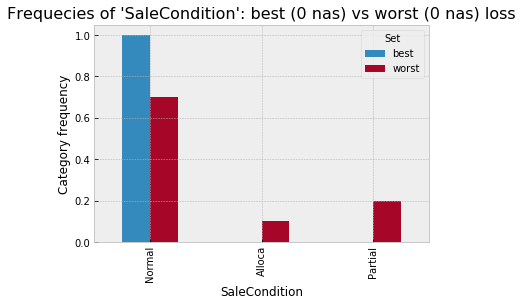

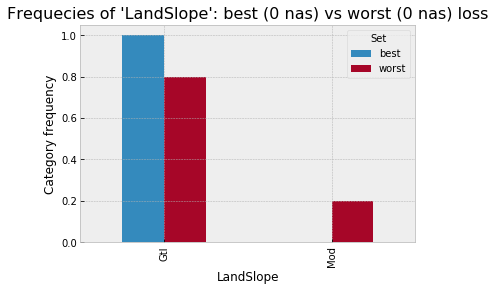

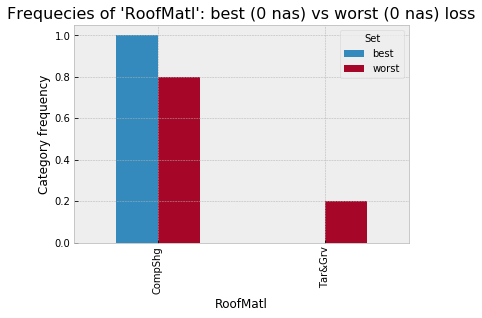

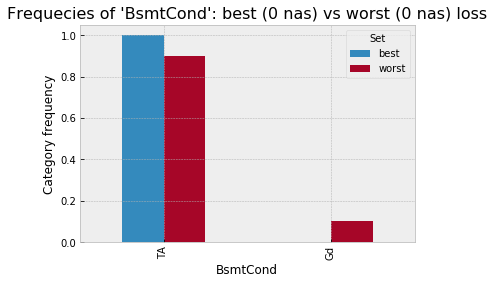

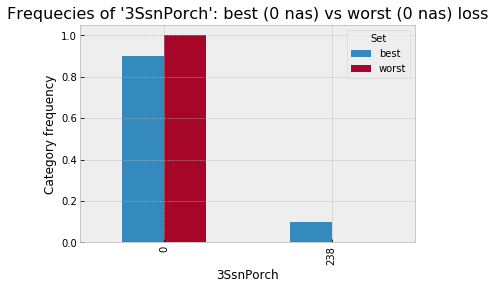

In [ ]:
plot_top_distributions(cat_freqs=cat_freqs, top_n=7)

### Continuous columns

In [ ]:
#export
def get_continuous_freqs_single_col(col:str, df:pd.DataFrame, best:np.ndarray, worst:np.ndarray,
                   nbins:int=50):
    "Computing the frequencies of continuous variables"
    _best = df.iloc[best][col].values
    _best_nas = element_comp(_best, "#na#")
    _best = _best[~_best_nas]
    _best_nas = _best_nas.sum()
    
    _worst = df.iloc[worst][col].values
    _worst_nas = element_comp(_worst, "#na#")
    _worst = _worst[~_worst_nas]
    _worst_nas = _worst_nas.sum()
    
    lim = (min(_best.min(), _worst.min()),
           max(_best.max(), _worst.max()))
    bins = np.linspace(lim[0], lim[1], nbins+1)
    _best, _ = np.histogram(_best, bins=bins)
    _worst, _ = np.histogram(_worst, bins=bins)
    centers = .5*(bins[1:] + bins[:-1])
    _best = pd.Series(index=centers, data=_best)
    _worst = pd.Series(index=centers, data=_worst)
    return _best, _worst, _best_nas, _worst_nas

def plot_best_vs_worst_continuous(col:str, best:pd.Series, 
                                  worst:pd.Series, best_nas:int=0,
                                  worst_nas:int=0):
    "Plotting best/worst distribution for a continuous variable"
    fig, ax = plt.subplots()
    
    assert np.allclose(best.index, worst.index)
    w = best.index[1] - best.index[0]  # assumes regular grid
    ax.bar(best.index-w/2, best.values, label="best", alpha=.9, width=w)
    ax.bar(worst.index+w/2, worst.values, label="worst", alpha=.9, width=w)

    ax.set_xlabel(col)
    ax.set_ylabel("Continuous value frequency")
    ax.set_title(f"Frequecies of '{col}': best ({best_nas:d} nas) vs worst ({worst_nas:d} nas) loss", fontsize=16)
    ax.legend(title="Set")
    plt.show()
    
def get_all_continuous_freqs(decoded_xs:pd.DataFrame, best:np.ndarray, worst:np.ndarray):
    cont_freqs = {}
    for col in to.cont_names:
        _best, _worst, _best_nas, _worst_nas = get_continuous_freqs_single_col(col, decoded_xs, best, worst, nbins=50)
        _score = distribution_similarity(_best, _worst)
        cont_freqs[col] = {"best": _best, "worst":_worst, "score": _score,
                           "best_nas": _best_nas, "worst_nas": _worst_nas}
        
    return cont_freqs

Iterating over the categorical columns computing the distributions and their similarities

In [ ]:
%%time
cont_freqs = get_all_continuous_freqs(decoded_xs, best_ix, worst_ix)

CPU times: user 44.7 ms, sys: 4.05 ms, total: 48.7 ms
Wall time: 49 ms


Plotting the value distributions for features of the selected best and worst predictions showing the most dissimilar distributions

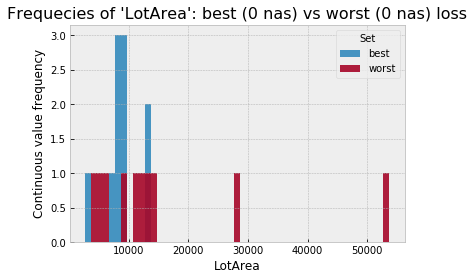

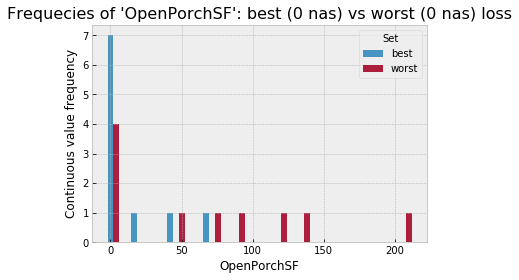

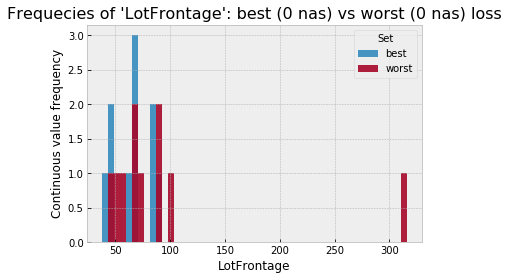

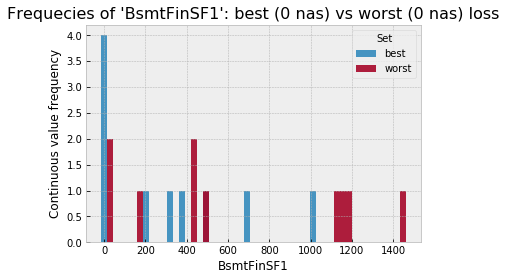

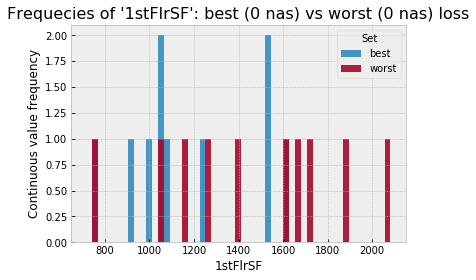

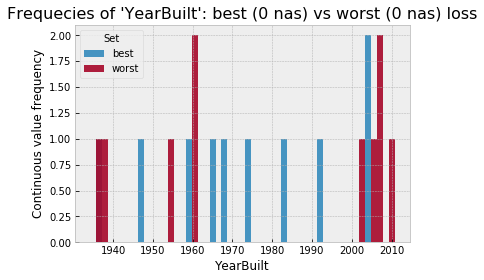

In [ ]:
plot_top_distributions(cont_freqs=cont_freqs, top_n=5)

Listing the continuous features whose value distribution most strongly deviates between best and worst predictions

In [ ]:
dis_diff_cont = pd.DataFrame([{"feature":col, "score": cont_freqs[col]["score"]} 
                             for col in cont_freqs]).sort_values("score", ascending=False)
display_all(dis_diff_cont.head())

,feature,score
0,LotArea,0.20
13,OpenPorchSF,0.12
15,BsmtFinSF1,0.08
14,LotFrontage,0.08
7,1stFlrSF,0.08


## Model inspection using SHAP values

Resources on the SHAP value and other methods/tools:
* shap on github: https://github.com/slundberg/shap
* shap article on arXiv: https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
* towardsdatascience blog: 
    * shap: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    * shap kernel: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    * LIME: https://medium.com/analytics-vidhya/explain-your-model-with-lime-5a1a5867b423
    * InterpetML: https://medium.com/analytics-vidhya/explain-your-model-with-microsofts-interpretml-5daab1d693b4
* ELI5: https://eli5.readthedocs.io/en/latest/
* post on model explainability: https://everdark.github.io/k9/notebooks/ml/model_explain/model_explain.nb.html

In [ ]:
#export
class FastaiModel(torch.nn.Module):
    "Wrapper class to make `TabularModel` usable with `shap.DeepExplainer`"
    def __init__(self, learn:Learner, to:TabularPandas):
        super().__init__()
        self.cat_ix = [_i for _i,_v in enumerate(to.valid.xs.columns) if _v in to.cat_names]
        self.cont_ix = [_i for _i,_v in enumerate(to.valid.xs.columns) if _v in to.cont_names]
        self.learn = learn
        
    def forward(self, X):
        return self.learn.model(X[:,self.cat_ix].long(), X[:,self.cont_ix].float())

Wrapping the learner

In [ ]:
model = FastaiModel(learn, to)

Computing SHAP values

In [ ]:
X = torch.from_numpy(to.valid.xs.values)
explainer = shap.DeepExplainer(model, X)

In [ ]:
shap_values = explainer.shap_values(X)

In [ ]:
#hide
explainer.expected_value[0], shap_values[0], X[0,:]

(11.884166,
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,


In [ ]:
shap.initjs()

Looking into the `TabularModel`

In [ ]:
#hide
shap.force_plot(explainer.expected_value[0], shap_values[0], to.valid.xs.iloc[0], link="identity")

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values, to.valid.xs, link="identity")

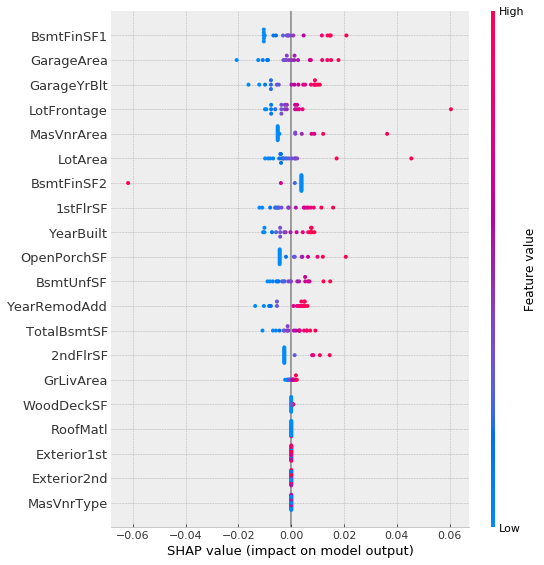

In [ ]:
shap.summary_plot(shap_values, to.valid.xs)

Looking into the ensemble model

In [ ]:
#hide
with open("models/ensemble.pckl", "rb") as f:
    ens = pickle.load(f)

In [ ]:
_X = X.detach().numpy()
ens_explainer = shap.TreeExplainer(ens, _X)
ens_shap_values = ens_explainer.shap_values(_X)

In [ ]:
shap.force_plot(ens_explainer.expected_value, ens_shap_values, to.valid.xs, link="identity")

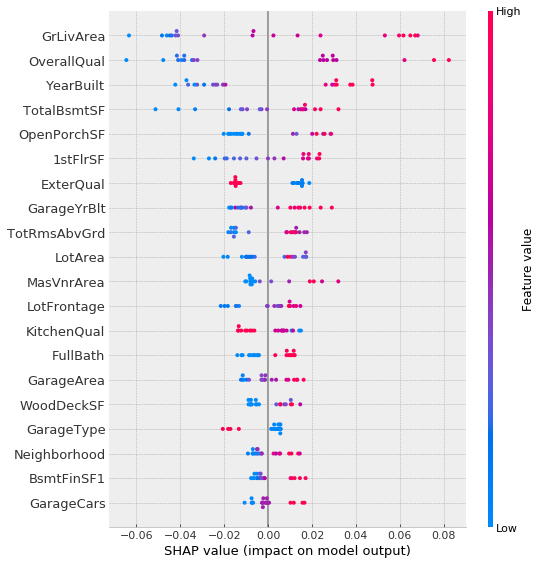

In [ ]:
shap.summary_plot(ens_shap_values, to.valid.xs)